In [74]:
import os
import joblib

import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import shap
import optuna
import category_encoders as ce
import optuna.visualization as vis

import xgboost as xgb
import lightgbm as lgb
import catboost as cat

from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [75]:
train = pd.read_csv('../data/clean_train1.csv')
test = pd.read_csv('../data/clean_test1.csv')

In [76]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1101 entries, 0 to 1100
Data columns (total 20 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   GP       1101 non-null   float64
 1   MIN      1101 non-null   float64
 2   PTS      1101 non-null   float64
 3   FGM      1101 non-null   float64
 4   FGA      1101 non-null   float64
 5   FG%      1101 non-null   float64
 6   3P Made  1101 non-null   float64
 7   3PA      1101 non-null   float64
 8   3P%      1101 non-null   float64
 9   FTM      1101 non-null   float64
 10  FTA      1101 non-null   float64
 11  FT%      1101 non-null   float64
 12  OREB     1101 non-null   float64
 13  DREB     1101 non-null   float64
 14  REB      1101 non-null   float64
 15  AST      1101 non-null   float64
 16  STL      1101 non-null   float64
 17  BLK      1101 non-null   float64
 18  TOV      1101 non-null   float64
 19  Target   1101 non-null   int64  
dtypes: float64(19), int64(1)
memory usage: 172.2 KB
None

,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,FTM,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,Target
0,-0.046431,-0.374135,-0.795033,-0.819002,-1.129274,1.166817,0.386891,-0.222559,50.0,-0.527282,-0.856955,0.721175,0.574642,0.622515,0.575923,-0.917968,-0.795424,0.690810,-1.218283,1
1,-1.547890,-0.738111,-0.795033,-0.957288,-0.667467,-1.445737,1.210295,1.381483,25.8,-0.991488,-0.685844,-1.454645,-1.095813,-0.567403,-0.791302,-1.138188,-0.795424,-0.754473,-2.431858,0
2,-0.675515,-1.017193,-0.300396,-0.348123,-0.610042,0.962458,-0.947395,-0.781462,0.0,0.293510,0.479642,-0.939706,-0.781027,-1.053931,-1.031504,-0.383897,-0.007412,0.690810,0.024180,0
3,1.270732,1.274604,1.221767,0.896423,1.204391,-1.075568,1.763193,1.763725,32.9,1.560218,1.332446,1.565884,0.124446,0.035627,0.072522,1.606109,1.618826,-0.754473,1.470639,1
4,-0.105482,0.385780,0.140615,-0.151647,0.222317,-1.198129,-0.947395,-0.781462,25.0,1.003075,1.239557,-0.922297,-0.508745,-1.246234,-1.031504,0.734019,1.346068,-0.123071,1.017282,0


In [118]:
X = train.drop('Target', axis=1)
y = train['Target']

# simple models

In [119]:
rfc = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=1234)
scores = cross_val_score(rfc, X, y, cv=10)
print(scores)
scores.mean()

[0.74774775 0.72727273 0.77272727 0.7        0.72727273 0.77272727
 0.69090909 0.72727273 0.78181818 0.69090909]


0.7338656838656838

In [120]:
rfc.fit(X, y)

RandomForestClassifier(max_depth=15, n_estimators=200, random_state=1234)

<AxesSubplot:xlabel='imp', ylabel='feats'>

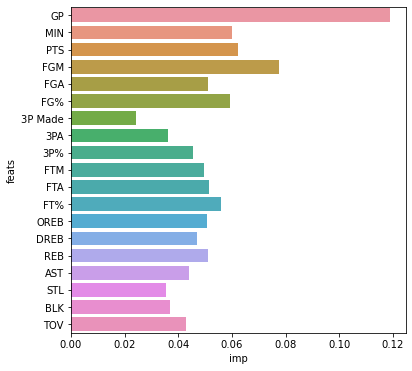

In [121]:
feat_imp = pd.DataFrame({
    'feats': X.columns.tolist(),
    'imp': rfc.feature_importances_
})

plt.figure(figsize=(6, 6))
sns.barplot(data=feat_imp, x='imp', y='feats')

In [123]:
probs = rfc.predict_proba(test)[:, 1]
probs

array([0.18980802, 0.07681222, 0.17859095, 0.03957936, 0.88227679,
       0.10226544, 0.86091667, 0.1205185 , 0.01160379, 0.13916805,
       0.33441729, 0.76627885, 0.88321225, 0.9125    , 0.09765276,
       0.78547028, 0.70228148, 0.1143526 , 0.9599881 , 0.908     ,
       0.0859201 , 0.05845004, 0.19521679, 0.06552652, 0.17308205,
       0.38277778, 0.04396916, 0.82371795, 0.77701183, 0.84758333,
       0.89956767, 0.9425    , 0.22638964, 0.95394643, 0.09147178,
       0.98033333, 0.87332418, 0.90056061, 0.88959848, 0.93666667,
       0.06036573, 0.83492891, 0.12858349, 0.965     , 0.0972751 ,
       0.08703603, 0.93      , 0.8642602 , 0.7812024 , 0.06078753,
       0.21082143, 0.12844695, 0.71688177, 0.20741361, 0.91683333,
       0.15691856, 0.06666667, 0.0671646 , 0.22672384, 0.00728157,
       0.78723389, 0.73016601, 0.05630093, 0.19130634, 0.12584597,
       0.90128788, 0.85126887, 0.19589286, 0.63656647, 0.10751938,
       0.15302527, 0.19766288, 0.28635714, 0.75761689, 0.19039

In [176]:
for i, val in enumerate(probs):
    if 0.38 < val < 0.65:
        print(i, val)

25 0.3827777777777777
68 0.6365664699389078
100 0.5143148833973643
127 0.5987499999999998
129 0.4073877994610753
148 0.5417738095238096
240 0.48748601354661114
346 0.5106966422466424
373 0.5106966422466424
420 0.48748601354661114
478 0.5987499999999998
496 0.5302797619047618
540 0.5113392907204937
546 0.5417738095238096


- 100
- 127 ----
- 129 ----
- 148 ----
- 240
- 346 ----
- 373
- 420 ----
- 496 ----
- 540
- 546

In [177]:
rfc_preds = rfc.predict(test)

sub = pd.DataFrame({
    'prediction': rfc_preds
})
sub.iloc[[420, 129, 25], 0] = 1
sub.iloc[[346, 496, 148, 127], 0] = 0
# sub.iloc[[496], 0] = 0
# sub.iloc[[148], 0] = 0

print(sub['prediction'].value_counts())
print(sub.shape)
sub.head()

0    289
1    266
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [178]:
sub.to_csv('../submissions/rfc14.csv', index=False)

In [113]:
pseudo_test = test.copy()
best_sub = pd.read_csv('../submissions/rfc3.csv')['prediction']
pseudo_test['Target'] = best_sub

combine = train.append(pseudo_test)
combine = combine.sample(frac=1).reset_index(drop=True)

px = combine.drop('Target', axis=1)
py = combine['Target']

rfc.fit(px, py)

rfc_preds = rfc.predict(test)

sub = pd.DataFrame({
    'prediction': rfc_preds
})

print(sub['prediction'].value_counts())
print(sub.shape)
sub.to_csv('../submissions/rfc4.csv', index=False)
sub.head()
# print(combine.shape)
# combine.head()

0    288
1    267
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [117]:
rfc.predict_proba(test)

array([[0.94363823, 0.05636177],
       [0.96087651, 0.03912349],
       [0.9123206 , 0.0876794 ],
       ...,
       [0.03      , 0.97      ],
       [0.94206355, 0.05793645],
       [0.03313636, 0.96686364]])

In [168]:
554 / 555

0.9981981981981982

# boosting

In [62]:
def cross_validate(model, X, y, n_folds=10):
    scores = []
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(
            train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
#             eval_metric='logloss',
            early_stopping_rounds=100,
            verbose=0,
            use_best_model=True,
        )

        preds = model.predict(valid_x)
        score = accuracy_score(valid_y, preds)
        scores.append(score)
        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

In [66]:
def get_kfold_prediction(model, X, y, test_data, n_folds=10):
    scores = []
    oof_probs = np.zeros(test_data.shape[0])
    kf = KFold(n_splits=n_folds)

    for fold, (train_index, valid_index) in tqdm(enumerate(kf.split(X)), total=n_folds):

        train_x, valid_x = X.iloc[train_index], X.iloc[valid_index]
        train_y, valid_y = y[train_index], y[valid_index]

        model.fit(
            train_x, 
            train_y, 
            eval_set=[(valid_x, valid_y)], 
#             eval_metric='logloss',
            early_stopping_rounds=100,
            verbose=0,
            use_best_model=True,
        )

        preds = model.predict(valid_x)

        # change metric according to requirement
        score = accuracy_score(valid_y, preds)
        scores.append(score)

        # change this according to requirement
        oof_probs += model.predict_proba(test_data)[:, 1] / n_folds

        print(f"Fold {fold + 1}: {score:.6f}")

    print(f'Mean Score: {np.mean(scores)}')

    return oof_probs

# lightgbm

In [33]:
# change the objective and metric

lgb_params = {
#     'objective': 'classification',
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.25,
    'max_depth': 7,
    'num_leaves': 64,  
    'max_bin': 512,
    'min_child_samples': 32,
    'subsample': 0.75,
    # 'bagging_freq': 10,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    'early_stopping_round': 100,
    # 'categorical_feature': '',
    # 'min_child_weight': 0.01,
    # 'colsample_bytree': 0.8,
    # 'colsample_bynode': 0.8,
    # 'random_strength': 2,
    # 'one_hot_max_size': 4,
    'verbose': -1,
    'seed': 1234,
    'n_jobs': -1,
}

lgb_model = lgb.LGBMClassifier(**lgb_params)

In [28]:
cross_validate(lgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.696197
Early stopping, best iteration is:
[12]	valid_0's binary_logloss: 0.545442
Fold 1: 0.774775
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.669585
Early stopping, best iteration is:
[11]	valid_0's binary_logloss: 0.549594
Fold 2: 0.745455
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.559332
Early stopping, best iteration is:
[34]	valid_0's binary_logloss: 0.505147
Fold 3: 0.772727
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.797037
Early stopping, best iteration is:
[6]	valid_0's binary_logloss: 0.603767
Fold 4: 0.709091
Training until validation scores don't improve for 100 rounds
[100]	valid_0's binary_logloss: 0.588147
Early stopping, best iteration is:
[9]	valid_0's binary_logloss: 0.533841
Fold 5: 0.772727
Training until validation s

In [34]:
lgb_probs = get_kfold_prediction(lgb_model, X, y, test) 

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 0.774775
Fold 2: 0.745455
Fold 3: 0.772727
Fold 4: 0.709091
Fold 5: 0.772727
Fold 6: 0.709091
Fold 7: 0.772727
Fold 8: 0.672727
Fold 9: 0.790909
Fold 10: 0.690909
Mean Score: 0.7411138411138412


In [55]:
lgb_preds = np.where(lgb_probs >= 0.5, 1, 0)

sub = pd.DataFrame({
    'prediction': lgb_preds
})

print(sub['prediction'].value_counts())
print(sub.shape)
sub.head()

0    291
1    264
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [39]:
sub.to_csv('../submissions/lgb2.csv', index=False)

# xgboost

In [50]:
# change the objective

xgb_params = {
    'objective': 'reg:squarederror',
    'booster': 'gbtree',
    'n_estimators': 5000,
    'max_depth': 7,
    'learning_rate': 0.05,
#     'gamma': 10,
    # 'min_child_weight': 0.4,
    'subsample': 0.9,
#     'colsample_bytree': 0.8,
    # 'colsample_bylevel': 0.4,
    # 'colsample_bynode': 0.6,
    'reg_alpha': 0.01,
    'reg_lambda': 0.5,
    # 'scale_pos_weight': 4,
    # 'importance_type': 'gain',
    # 'max_delta_step': ,
    # 'base_score': ,
    # 'tree_method': 'auto',
    # 'missing': ,
    # 'num_parallel_tree': ,
    # 'monotone_constraints': ,
    # 'interaction_constraints': ,
    'n_jobs': -1,
    'random_state': 1234,
    'verbosity': 1,
}

xgb_model = xgb.XGBClassifier(**xgb_params)

In [51]:
cross_validate(xgb_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 0.756757
Fold 2: 0.736364
Fold 3: 0.772727
Fold 4: 0.681818
Fold 5: 0.727273
Fold 6: 0.736364
Fold 7: 0.763636
Fold 8: 0.681818
Fold 9: 0.772727
Fold 10: 0.672727
Mean Score: 0.7302211302211302


In [52]:
xgb_probs = get_kfold_prediction(xgb_model, X, y, test)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 0.756757
Fold 2: 0.736364
Fold 3: 0.772727
Fold 4: 0.681818
Fold 5: 0.727273
Fold 6: 0.736364
Fold 7: 0.763636
Fold 8: 0.681818
Fold 9: 0.772727
Fold 10: 0.672727
Mean Score: 0.7302211302211302


In [53]:
xgb_preds = np.where(xgb_probs >= 0.5, 1, 0)

sub = pd.DataFrame({
    'prediction': xgb_preds
})

print(sub['prediction'].value_counts())
print(sub.shape)
sub.head()

0    291
1    264
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [54]:
sub.to_csv('../submissions/xgb1.csv', index=False)

# catboost

In [60]:
cat_params = {
    'n_estimators': 2000,
    'learning_rate': 0.25,
    'max_depth': 7,
    'reg_lambda': 10,
    'early_stopping_rounds': 100,
    # 'cat_features': cat_cols,
    # 'subsample': 0.8,
    # 'colsample_bylevel': 0.8,
    # 'bagging_temperature': 0.5,
    # 'random_strength': 2,
    # 'one_hot_max_size': 4,
    'verbose': 0,
    'random_state': 1234,
    'thread_count': -1
}
cat_model = cat.CatBoostClassifier(**cat_params)

In [65]:
cross_validate(cat_model, X, y)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 0.738739
Fold 2: 0.709091
Fold 3: 0.763636
Fold 4: 0.745455
Fold 5: 0.772727
Fold 6: 0.718182
Fold 7: 0.800000
Fold 8: 0.718182
Fold 9: 0.827273
Fold 10: 0.681818
Mean Score: 0.7475102375102375


In [67]:
cat_probs = get_kfold_prediction(cat_model, X, y, test)

  0%|          | 0/10 [00:00<?, ?it/s]

Fold 1: 0.738739
Fold 2: 0.709091
Fold 3: 0.763636
Fold 4: 0.745455
Fold 5: 0.772727
Fold 6: 0.718182
Fold 7: 0.800000
Fold 8: 0.718182
Fold 9: 0.827273
Fold 10: 0.681818
Mean Score: 0.7475102375102375


In [70]:
cat_model.fit(X, y)

In [71]:
# cat_preds = np.where(cat_probs >= 0.5, 1, 0)
cat_preds = cat_model.predict(test)

sub = pd.DataFrame({
    'prediction': cat_preds
})

print(sub['prediction'].value_counts())
print(sub.shape)
sub.head()

0    289
1    266
Name: prediction, dtype: int64
(555, 1)


,prediction
0,0
1,0
2,0
3,0
4,1


In [72]:
sub.to_csv('../submissions/cat2.csv', index=False)